In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn;seaborn.set()

In [2]:
data=pd.read_csv('SeattleBike-master/FremontBridge.csv',index_col='Date',parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [3]:
data.drop(data['2015-07-01':].index,inplace=True)

In [4]:
data.columns=['Total','East','West']
data.head()

,Total,East,West
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


Text(0, 0.5, 'weekly trips')

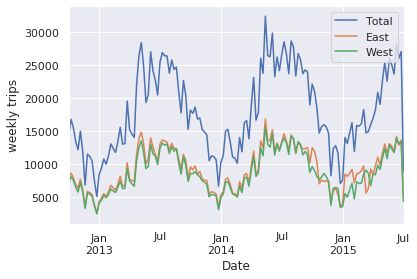

In [5]:
data.resample('W').sum().plot()
plt.ylabel('weekly trips')

## Step 1: Transforming the Data

In [6]:
pivoted = data.pivot_table(['East','West'],index=data.index.date,
                           columns=data.index.hour,fill_value=0)

pivoted.head()

East                                       ... West                 \
Date         0   1  2  3  4   5    6    7    8    9   ...   14   15   16   17   
2012-10-03    4   4  1  2  6  21  105  257  291  172  ...   51   92  182  391   
2012-10-04    7   3  3  0  7  15   91  230  284  147  ...   56   74  161  353   
2012-10-05    4   4  4  2  7  18   68  218  251  131  ...   62   84  190  290   
2012-10-06    8  10  7  1  4   3   12   17   58   59  ...  114   96   76   73   
2012-10-07    6  12  2  4  1   6    9   14   43   67  ...  115  109   93   73   

                                      
Date         18   19  20  21  22  23  
2012-10-03  258   69  51  38  25  12  
2012-10-04  241  107  56  39  21  30  
2012-10-05  209   73  41  31  26  16  
2012-10-06   55   38  18  15  20  19  
2012-10-07   45   23  36  35   9  11  

[5 rows x 48 columns]

In [7]:
X=pivoted.values
X.shape

(1001, 48)

## Step 2: Visualizing the Data

In [8]:
from sklearn.decomposition import PCA
Xpca=PCA(0.90).fit_transform(X)

In [14]:
Xpca.shape

(1001, 2)

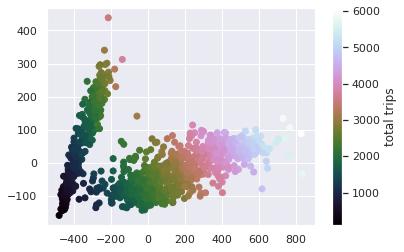

In [9]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,cmap='cubehelix')
plt.colorbar(label='total trips')

## Step 3: Unsupervised Clustering

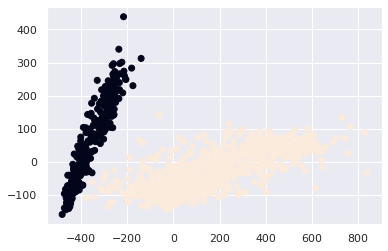

In [10]:
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(2,covariance_type='full',random_state=0)
gmm.fit(Xpca)
cluster_label=gmm.predict(Xpca)
plt.scatter(Xpca[:,0],Xpca[:,1],c=cluster_label)

In [11]:
pivoted['Cluster']=cluster_label
data=data.join(pivoted['Cluster'],on=data.index.date)
data

,Total,East,West,Cluster
Date,,,,
2012-10-03 00:00:00,13.0,4.0,9.0,1
2012-10-03 01:00:00,10.0,4.0,6.0,1
2012-10-03 02:00:00,2.0,1.0,1.0,1
2012-10-03 03:00:00,5.0,2.0,3.0,1
2012-10-03 04:00:00,7.0,6.0,1.0,1
...,...,...,...,...
2015-06-30 19:00:00,282.0,114.0,168.0,1
2015-06-30 20:00:00,162.0,67.0,95.0,1
2015-06-30 21:00:00,104.0,42.0,62.0,1


In [12]:
by_hour=data.groupby(['Cluster',data.index.time]).mean()
by_hour.head()

Total      East       West
Cluster                                         
0       00:00:00  17.579288  7.475728  10.103560
        01:00:00  10.592233  4.851133   5.741100
        02:00:00   7.462541  3.674267   3.788274
        03:00:00   4.394822  2.533981   1.860841
        04:00:00   4.097087  2.003236   2.093851

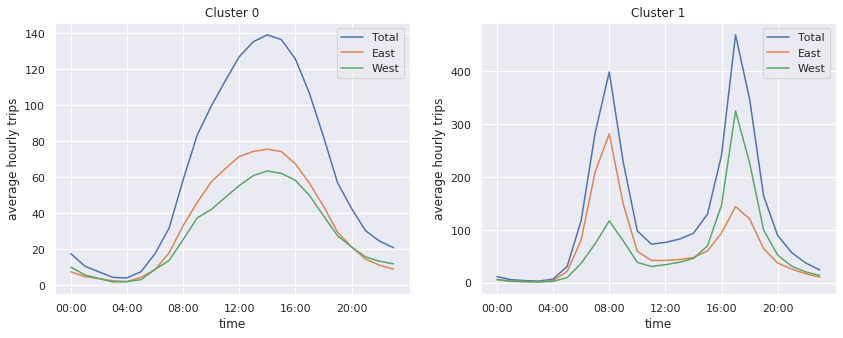

In [14]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
hourly_ticks=4*60*60*np.arange(6)

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i],xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

## Step 4： Analysis the cluster

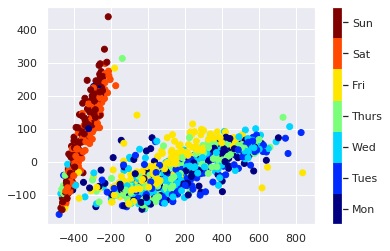

In [15]:
import datetime as dt
dayofweek=pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:,0],Xpca[:,1],c=dayofweek,
           cmap=plt.cm.get_cmap('jet',7))
cb=plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
plt.clim(-0.5,6.5)

In [16]:
results=pd.DataFrame({'cluster':cluster_label,
                     'is_weekend':(dayofweek>4),
                     'weekday':pivoted.index.map(lambda x: x.strftime('%a'))},
                    index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,1,False,Wed
2012-10-04,1,False,Thu
2012-10-05,1,False,Fri
2012-10-06,0,True,Sat
2012-10-07,0,True,Sun


In [17]:
weekend_workdays=results.query('cluster==1 and is_weekend')
len(weekend_workdays)

0

In [18]:
midweek_holidays=results.query('cluster==0 and not is_weekend')
len(midweek_holidays)

23

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal=USFederalHolidayCalendar()
holidays=cal.holidays('2012','2016',return_name=True)
holidays[-6:]

2015-09-07        Labor Day
2015-10-12     Columbus Day
2015-11-11     Veterans Day
2015-11-26     Thanksgiving
2015-12-25        Christmas
2016-01-01    New Years Day
dtype: object

In [21]:
holidays_all=pd.concat([holidays,'Day Before '+holidays.shift(-1,'D'),
                        'Day After '+holidays.shift(1,'D')])
holidays_all=holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Martin Luther King Jr. Day
2012-01-16               Martin Luther King Jr. Day
dtype: object

In [22]:
holidays_all.name='name'
joined=midweek_holidays.join(holidays_all)
set(joined['name'])

{'Christmas',
 'Day After Christmas',
 'Day After Thanksgiving',
 'Day Before Christmas',
 'July 4th',
 'Labor Day',
 'Memorial Day',
 'New Years Day',
 'Thanksgiving'}

In [24]:
joined

,cluster,is_weekend,weekday,name
2012-11-22,0,False,Thu,Thanksgiving
2012-11-23,0,False,Fri,Day After Thanksgiving
2012-12-24,0,False,Mon,Day Before Christmas
2012-12-25,0,False,Tue,Christmas
2013-01-01,0,False,Tue,New Years Day
2013-05-27,0,False,Mon,Memorial Day
2013-07-04,0,False,Thu,July 4th
2013-09-02,0,False,Mon,Labor Day
2013-11-28,0,False,Thu,Thanksgiving
2013-11-29,0,False,Fri,Day After Thanksgiving


In [23]:
set(holidays)-set(joined.name)

{'Columbus Day',
 'Martin Luther King Jr. Day',
 'Presidents Day',
 'Veterans Day'}

## What's happend in three isolated Fridays?

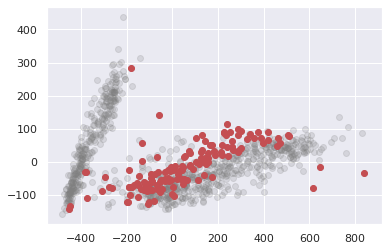

In [25]:
fridays=(dayofweek==4)
plt.scatter(Xpca[:,0],Xpca[:,1],c='gray',alpha=0.2)
plt.scatter(Xpca[fridays,0],Xpca[fridays,1],c='r')

In [28]:
weird_fridays=pivoted.index[fridays & (Xpca[:,0]> 600)]
weird_fridays

Index([2013-05-17, 2014-05-16, 2015-05-15], dtype='object')

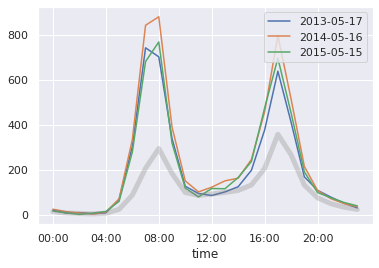

In [29]:
all_days=data.pivot_table('Total',index=data.index.time,columns=data.index.date)
all_days.loc[:,weird_fridays].plot()
all_days.mean(1).plot(color='gray',lw=5,alpha=0.3,
                     xticks=hourly_ticks)